In [76]:
import check
import pickle
import rockfish as rf
import rockfish.labs as rl
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [83]:
def generate_reports(src_file_path, syn_file_path, show_plot=False, show_report=False, interested_features=None, compute_best_feat = False):
    
    def plot_features(feature_nums):
        for ft in feature_nums:
            feature = f'feature_{ft}'
            
            fig, ax = plt.subplots()
            fig.set_figwidth(15)
            x = source_data.table["timestamp"]
            y1 = source_data.table[feature]
            y2 = syn_data.table[feature]
            
            min_len = min(len(x), len(y1), len(y2))
            
            x = x[-min_len:]
            y1 = y1[-min_len:]
            y2 = y2[-min_len:]
            x = pd.to_datetime(x)
            x = x.astype(np.int64) // 10**9
            
            ax.plot(x, y1, "g", label="True Value")
            ax.plot(x, y2, "b", label="Synthetic Value")
            
            # Calculate and plot the linear regression line for the true values
            # change x to units
            
            coeffs_true = np.polyfit(x, y1, 1)
            linear_fit_true = np.poly1d(coeffs_true)
            ax.plot(x, linear_fit_true(x), "g--", label="True Value Linear Fit")
            
            # Calculate and plot the linear regression line for the synthetic values
            coeffs_syn = np.polyfit(x, y2, 1)
            linear_fit_syn = np.poly1d(coeffs_syn)
            ax.plot(x, linear_fit_syn(x), "b--", label="Synthetic Value Linear Fit")
            
            plt.title(feature)
            plt.legend()
            plt.show()
        
    
    source_path = src_file_path
    timestamp_path = source_path.replace('.csv', '_timestamp.csv')
    if not syn_file_path:
        syn_path = f'syn_{source_path}'
    else:
        syn_path = syn_file_path
    source = pd.read_csv(source_path)
    ts = pd.read_csv(timestamp_path)
    syn = pd.read_csv(syn_path)
    source['timestamp'] = ts['timestamp']
    syn['timestamp'] = ts['timestamp'] 
    
    source_data = rf.Dataset.from_pandas("source", source)
    syn_data = rf.Dataset.from_pandas("syn", syn)
    
    
    overall_fidelity = rl.metrics.marginal_dist_score(source_data, syn_data)
    print(f"Overall Marginal Distribution Score: {syn_file_path}", overall_fidelity)
    best_fidelity = {}
    if compute_best_feat:
        best_fidelity = {feature: None for feature in source.columns if feature.startswith('feature_')}
        
        for feature in best_fidelity.keys():
            source_x = source[[feature]]
            syn_x = syn[[feature]]
            source_x['timestamp'] = ts['timestamp']
            syn_x['timestamp'] = ts['timestamp']
            source_data_for_fid = rf.Dataset.from_pandas("source", source_x)
            syn_data_for_fid = rf.Dataset.from_pandas("syn", syn_x) 
            best_fidelity[feature] = rl.metrics.marginal_dist_score(source_data_for_fid, syn_data_for_fid)
        
        print(f"Best Fidelity: {max(best_fidelity, key=best_fidelity.get)} with fidelity: {best_fidelity[max(best_fidelity, key=best_fidelity.get)]}")
    
    
    if show_plot:
        if interested_features:
            plot_features(interested_features)
        else:
            plot_features(list(range(25)))
            
    
    if show_report:
        actions = pickle.load(open('runtime_conf.pkl', 'rb'))
        actions.actions
        config = actions.actions['train-tab-gan'].config()
        check.report([source_data,syn_data], config, output_file='rep.html')
        
    return overall_fidelity, best_fidelity

Overall Marginal Distribution Score: ./syn_location3_hours 6/location3_2023-08-06_hour01.csv 0.5839743589743589
Best Fidelity: feature_19 with fidelity: 0.9


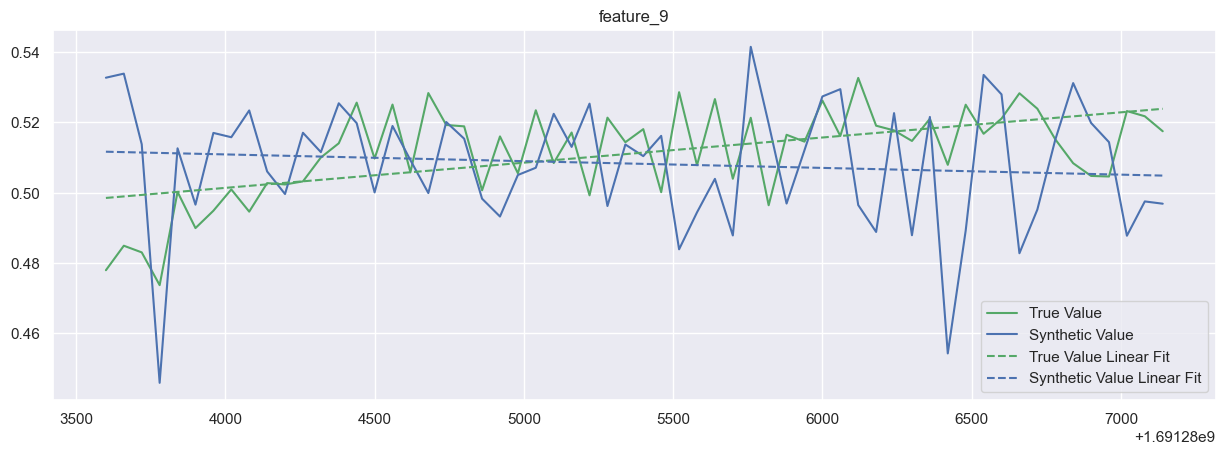

Overall Marginal Distribution Score: ./syn_location3_hours 5/location3_2023-08-06_hour01.csv 0.5762820512820512
Best Fidelity: feature_9 with fidelity: 0.925


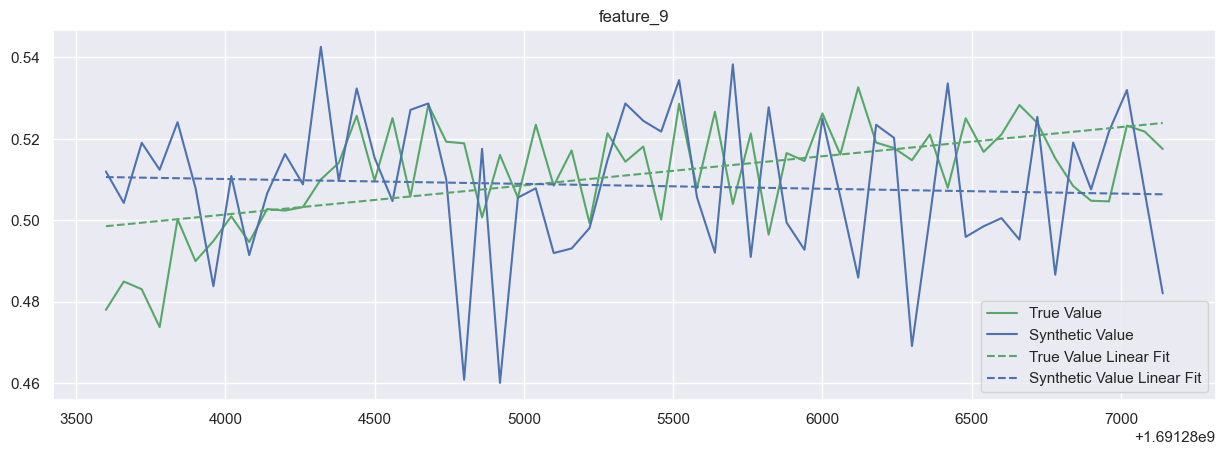

Overall Marginal Distribution Score: ./syn_location3_hours 2/location3_2023-08-06_hour01.csv 0.5871794871794871
Best Fidelity: feature_9 with fidelity: 0.9083333333333334


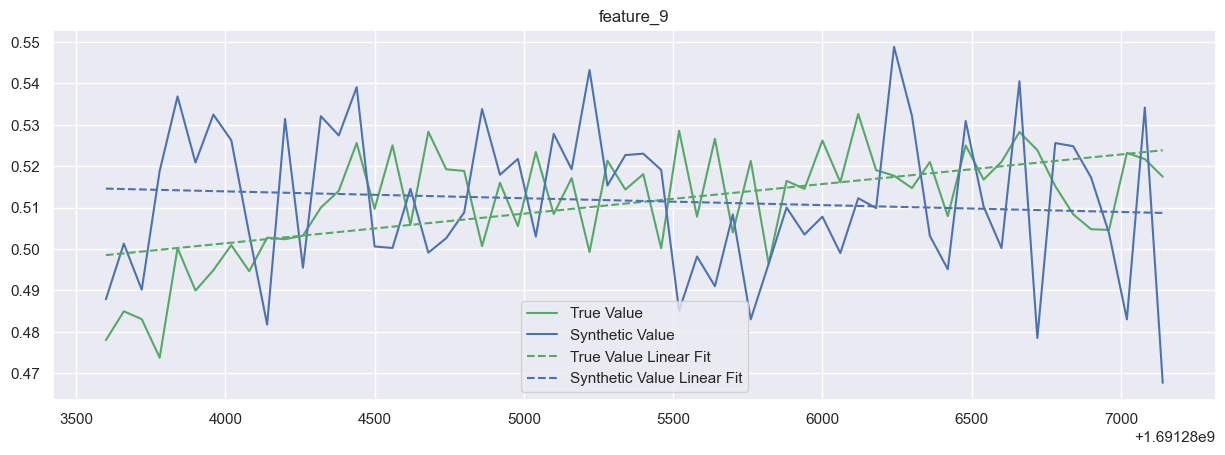

Overall Marginal Distribution Score: ./syn_location3_hours 3/location3_2023-08-06_hour01.csv 0.6070512820512822
Best Fidelity: feature_12 with fidelity: 0.9166666666666666


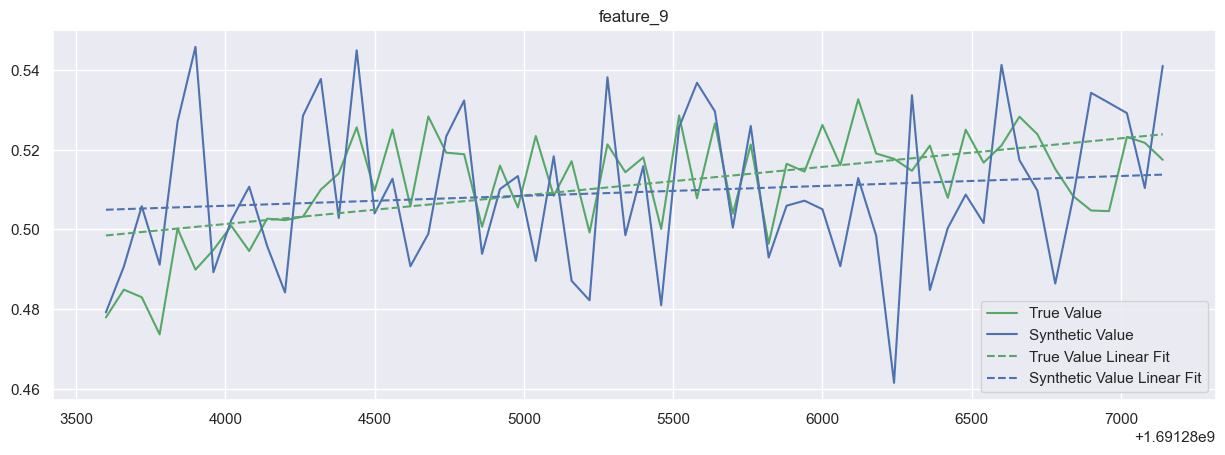

Overall Marginal Distribution Score: ./syn_location3_hours 4/location3_2023-08-06_hour01.csv 0.573076923076923
Best Fidelity: feature_9 with fidelity: 0.9083333333333333


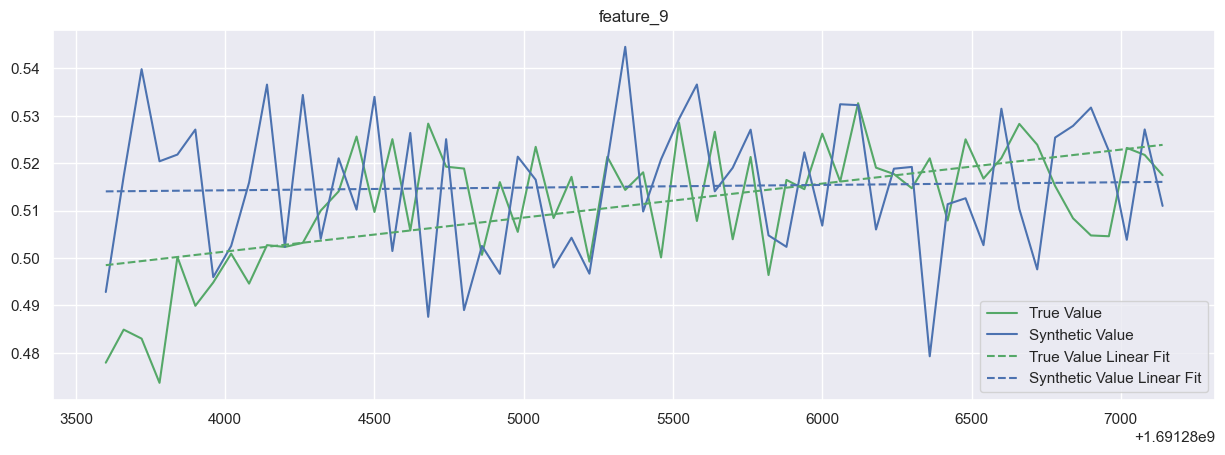

In [84]:
import glob
items = glob.glob('./syn_location3_hours [0-9]/location3_2023-08-06_hour01.csv')
fidelity_features = {i.split('/')[1]: None for i in items}
for i in items:
    _, bf = generate_reports('location3_hours/location3_2023-08-06_hour01.csv', i, show_plot=True, show_report=False, compute_best_feat=True, interested_features=[9])
    fidelity_features[i.split('/')[1]] = bf

In [71]:
[(k,x['feature_9']) for k,x in fidelity_features.items()]

[('syn_location3_hours 6', 0.8916666666666666),
 ('syn_location3_hours 5', 0.925),
 ('syn_location3_hours 2', 0.9083333333333334),
 ('syn_location3_hours 3', 0.9),
 ('syn_location3_hours 4', 0.9083333333333333)]